In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [48]:
print("---  Data Understanding & Cleaning ---")


# 1.1 Data Ingestion & Filtering
# We will load the data from the 'Finance&Economics_dataset.csv' file.
# **ACTION REQUIRED**: Ensure the CSV is in the same directory as this script.

try:
    # Load the dataset, parsing dates and handling comma-separated thousands
    df = pd.read_csv('finance_economics_dataset.csv', parse_dates=['Date'], index_col='Date', thousands=',')
    print("Successfully loaded data from 'finance_economics_dataset.csv'.")
except FileNotFoundError:
    print("Error: 'finance_economics_dataset.csv not found.")
    print("Please download the dataset from Kaggle and place it in the correct folder.")
    exit()

# Filter the dataset for the project's specified time range (2000-2008).
df = df.loc['2000-01-01':'2008-12-31']
print(f"\nFiltered data to the range: {df.index.min()} to {df.index.max()}")

# --- NEW CORE LOGIC: Filter for 'S&P 500' data ---
# The 'Stock Index' column is categorical. We must filter to analyze a single index.
if 'Stock Index' in df.columns:
    df = df[df['Stock Index'] == 'S&P 500'].copy()
    print("\nSuccessfully filtered the dataset to only include 'S&P 500' rows.")
else:
    print("\nWarning: 'Stock Index' column not found. Unable to filter for S&P 500 data.")

---  Data Understanding & Cleaning ---
Successfully loaded data from 'finance_economics_dataset.csv'.

Filtered data to the range: 2000-01-01 00:00:00 to 2008-03-18 00:00:00

Successfully filtered the dataset to only include 'S&P 500' rows.


In [53]:
# 1.2 Data Renaming and Cleaning
# Rename columns for consistency. We will use 'Close Price' for our S&P 500 analysis.
df = df.rename(columns={
    'Close Price': 'SP500_Price',
    'GDP Growth (%)': 'GDP',
    'Inflation Rate (%)': 'CPI',
    'Interest Rate (%)': 'InterestRate',
    'Unemployment Rate (%)': 'UnemploymentRate'
})

# Select only the relevant columns for the project to simplify the dataset.
relevant_columns = [
    'SP500_Price', 'Open Price', 'Daily High', 'Daily Low', 'Trading Volume',
    'GDP', 'CPI', 'UnemploymentRate', 'InterestRate', 'Consumer Confidence Index'
]
# Keep only columns that actually exist in the DataFrame
existing_relevant_columns = [col for col in relevant_columns if col in df.columns]
df = df[existing_relevant_columns]
print("\nSelected and renamed relevant columns for analysis.")

# Convert all remaining columns to numeric, coercing any errors to NaN.
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print("Converted all data columns to numeric type.")


Selected and renamed relevant columns for analysis.
Converted all data columns to numeric type.


In [58]:
# 1.3 Handle Missing Values
# After filtering and cleaning, some values might be missing.
if df.isnull().sum().any():
    print("\nMissing values found. Applying forward-fill and back-fill...")
    df_cleaned = df.ffill().bfill()
else:
    print("\nNo missing values found in the dataset.")
    df_cleaned = df.copy()

print("\nFinal cleaned dataset info:")
df_cleaned.info()
print("\nData is filtered, cleaned, and ready for analysis.")


No missing values found in the dataset.

Final cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036 entries, 2000-01-02 to 2008-03-16
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SP500_Price                1036 non-null   float64
 1   Open Price                 1036 non-null   float64
 2   Daily High                 1036 non-null   float64
 3   Daily Low                  1036 non-null   float64
 4   Trading Volume             1036 non-null   int64  
 5   GDP                        1036 non-null   float64
 6   CPI                        1036 non-null   float64
 7   UnemploymentRate           1036 non-null   float64
 8   InterestRate               1036 non-null   float64
 9   Consumer Confidence Index  1036 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 89.0 KB

Data is filtered, cleaned, and ready for analysis.



--- Week 2: Exploratory Data Analysis (EDA) ---

Generating time-series plots...
Saved 'timeseries_plots.png'


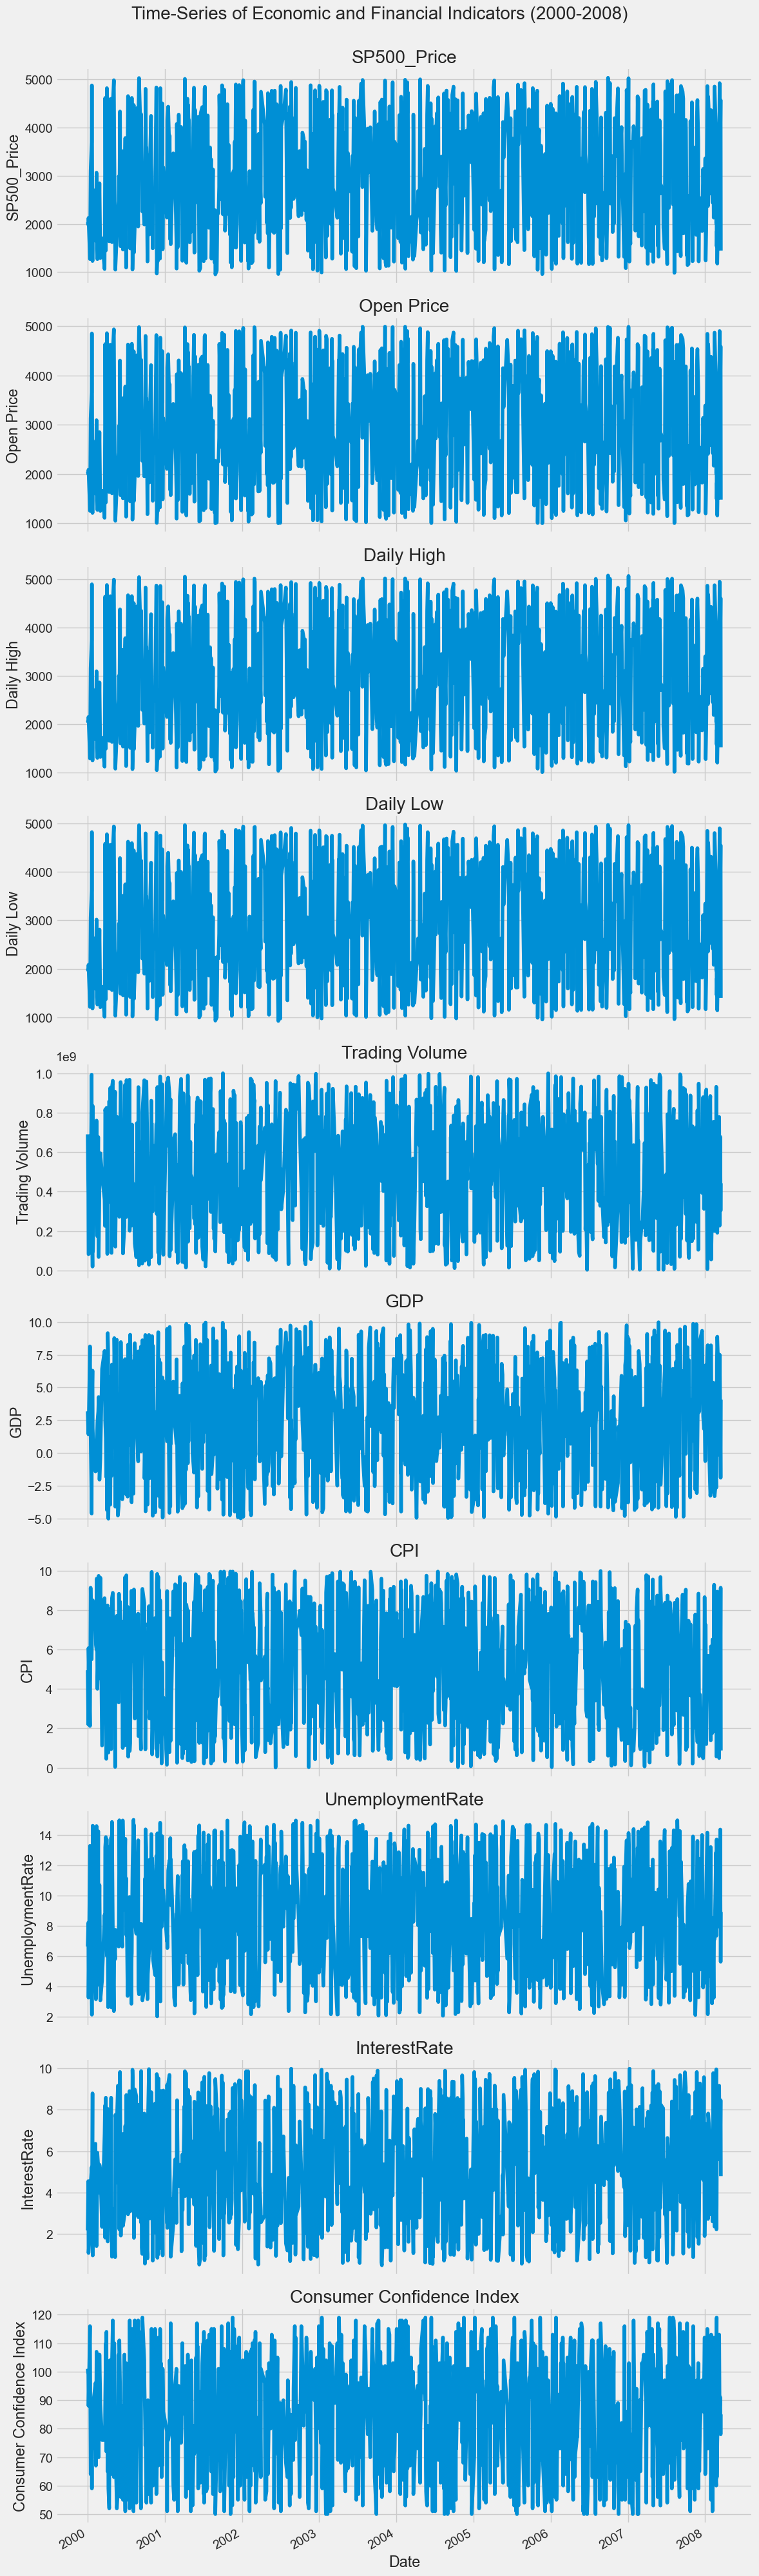

In [60]:
# ---  EXPLORATORY DATA ANALYSIS (EDA) ---

print("\n--- Week 2: Exploratory Data Analysis (EDA) ---")

# 2.1 Visualize Key Indicators
print("\nGenerating time-series plots...")
numeric_columns = df_cleaned.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(12, len(numeric_columns) * 4), sharex=True)
if len(numeric_columns) == 1: axes = [axes] # Handle case of single plot

for i, col in enumerate(numeric_columns):
    df_cleaned[col].plot(ax=axes[i], title=col)
    axes[i].set_ylabel(col)

plt.suptitle('Time-Series of Economic and Financial Indicators (2000-2008)', fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig('timeseries_plots.png')
print("Saved 'timeseries_plots.png'")


Generating correlation heatmap...
Saved 'correlation_heatmap.png'

Correlation matrix:
                           SP500_Price  Open Price  Daily High  Daily Low  \
SP500_Price                   1.000000    0.999679    0.999820   0.999819   
Open Price                    0.999679    1.000000    0.999826   0.999816   
Daily High                    0.999820    0.999826    1.000000   0.999757   
Daily Low                     0.999819    0.999816    0.999757   1.000000   
Trading Volume                0.012570    0.013168    0.012695   0.012981   
GDP                          -0.042625   -0.042998   -0.042518  -0.043593   
CPI                          -0.044865   -0.043553   -0.043544  -0.043449   
UnemploymentRate             -0.014074   -0.014015   -0.014619  -0.014052   
InterestRate                  0.014849    0.015106    0.015560   0.014543   
Consumer Confidence Index    -0.013605   -0.012872   -0.012662  -0.012781   

                           Trading Volume       GDP       CPI  \

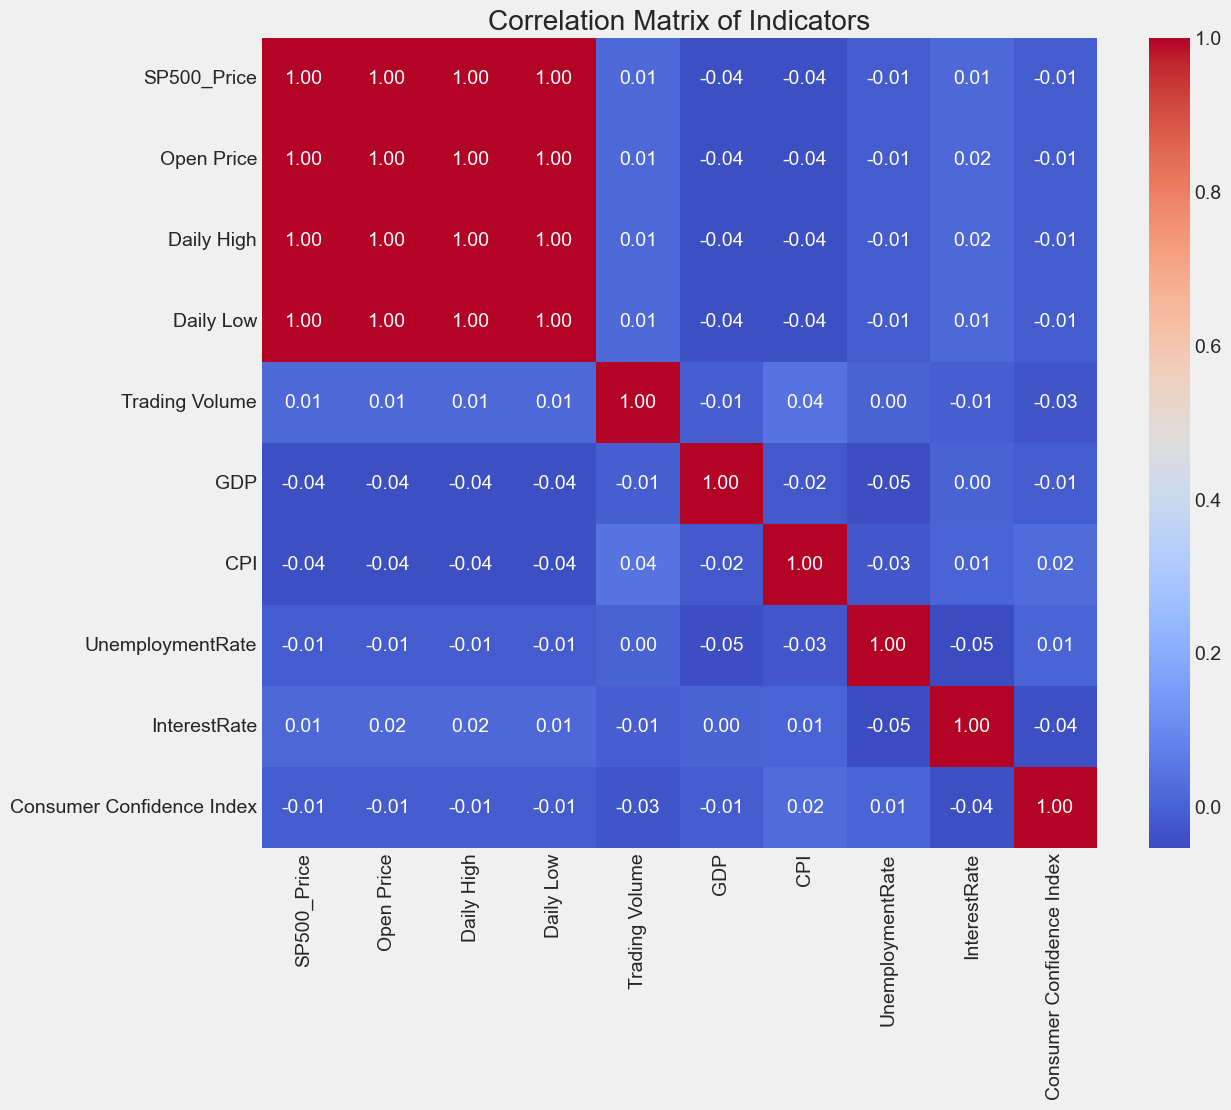

In [62]:
# 2.2 Generate Correlation Heatmap
print("\nGenerating correlation heatmap...")
correlation_matrix = df_cleaned.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Indicators')
plt.savefig('correlation_heatmap.png')
print("Saved 'correlation_heatmap.png'")

print("\nCorrelation matrix:")
print(correlation_matrix)
print("\nWeek 2 complete. EDA visualizations have been generated.")

In [64]:
print("\n--- Feature Engineering ---")

df_featured = df_cleaned.copy()

# 3.1 Create Lag Features
if 'GDP' in df_featured.columns:
    df_featured['GDP_Lag_90D'] = df_featured['GDP'].shift(90)
    print("Created 'GDP_Lag_90D' feature.")
else:
    print("Warning: 'GDP' column not found. Skipping GDP lag feature creation.")


--- Feature Engineering ---
Created 'GDP_Lag_90D' feature.


In [66]:
# 3.2 Create Rolling Averages and Returns for S&P 500 Price
if 'SP500_Price' in df_featured.columns:
    df_featured['SP500_MA_90D'] = df_featured['SP500_Price'].rolling(window=90).mean()
    df_featured['SP500_MA_365D'] = df_featured['SP500_Price'].rolling(window=365).mean()
    df_featured['SP500_Log_Return'] = np.log(df_featured['SP500_Price'] / df_featured['SP500_Price'].shift(1))
    print("Created 'SP500_Price' moving average and log return features.")
else:
    print("Warning: 'SP500_Price' column not found. Skipping feature creation.")

Created 'SP500_Price' moving average and log return features.


In [68]:
# Drop NaN values created by feature engineering
df_featured = df_featured.dropna()
print("\nDropped NaN values created during feature engineering.")

print("\nDataset with new features (last 5 rows):")
print(df_featured.tail())


Dropped NaN values created during feature engineering.

Dataset with new features (last 5 rows):
            SP500_Price  Open Price  Daily High  Daily Low  Trading Volume  \
Date                                                                         
2008-03-08      3954.22     3925.00     3997.72    3919.04       778294296   
2008-03-10      4917.12     4901.64     4950.15    4897.77       227063782   
2008-03-13      3575.34     3593.86     3617.87    3557.28       677342840   
2008-03-15      4566.91     4589.59     4607.56    4545.69       303579301   
2008-03-16      1448.47     1477.52     1523.86    1402.69       442387176   

             GDP   CPI  UnemploymentRate  InterestRate  \
Date                                                     
2008-03-08 -0.12  0.49             13.63          9.16   
2008-03-10  7.51  4.90              7.92          5.76   
2008-03-13  2.96  3.98             14.36          5.91   
2008-03-15 -1.88  9.15              5.61          8.46   
2008-03


Visualizing engineered features...
Saved 'sp500_with_ma.png'

Week 3 complete. Feature engineering is done.

Project progress for mid-program presentation is ready!


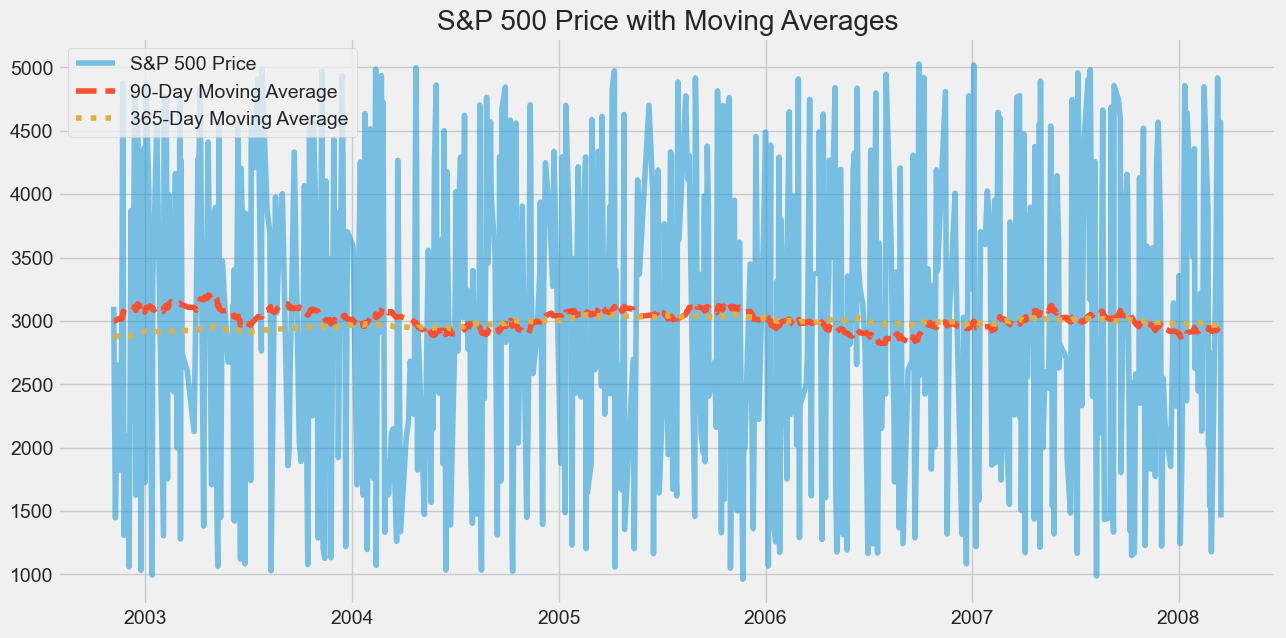

In [70]:
# Visualize some of the new features
if 'SP500_Price' in df_featured.columns:
    print("\nVisualizing engineered features...")
    plt.figure(figsize=(14, 7))
    plt.plot(df_featured.index, df_featured['SP500_Price'], label='S&P 500 Price', alpha=0.5)
    plt.plot(df_featured.index, df_featured['SP500_MA_90D'], label='90-Day Moving Average', linestyle='--')
    plt.plot(df_featured.index, df_featured['SP500_MA_365D'], label='365-Day Moving Average', linestyle=':')
    plt.title('S&P 500 Price with Moving Averages')
    plt.legend()
    plt.savefig('sp500_with_ma.png')
    print("Saved 'sp500_with_ma.png'")
else:
    print("\nSkipping visualization of S&P 500 features as the column is not available.")

print("\nWeek 3 complete. Feature engineering is done.")
print("\nProject progress for mid-program presentation is ready!")